# <center>Классификация фильмов по жанрам
Данные взяты с [соревнования на *Kaggle*](https://www.kaggle.com/competitions/sf-dl-movie-genre-classification/overview)

Описание столбцов в датасете:

* `name` - название фильма
* `text` - описание фильма

Целевой признак:

* `genre` - жанр фильма

<a id='start'></a>

## <center>Знакомство с данными

In [3]:
import pandas as pd
import numpy as np

import itertools
from IPython.display import Markdown

import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

from wordcloud import WordCloud

import nltk

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf

import os as _os

_os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8\bin")
pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
RANDOM_STATE = 42
N_JOBS = -1

In [2]:
data = pd.read_csv('../data/train.csv.zip')
display(
    Markdown('### Пример данных'),
    data.sample(3, random_state=RANDOM_STATE),
    Markdown(f'### Количество пропусков: {data.isna().sum().sum()}'),
    Markdown(f'### Количество дубликатов: {data.duplicated().sum()}'),
    Markdown('### Характеристики признаков'),
    data.describe().T
)

### Пример данных

,name,genre,text
5089,Sisterhood (2008),comedy,"Catherine St.John-Burke is an independent, up..."
30323,Idylle (1983),short,"Beginning of the century. In a train, a young..."
6415,The Lost Skeleton Returns Again (2009),comedy,"Jerranium 90, a ""little rock"" that made all t..."


### Количество пропусков: 0

### Количество дубликатов: 0

### Характеристики признаков

,count,unique,top,freq
name,54214,54214,Oscar et la dame rose (2009),1
genre,54214,27,drama,13613
text,54214,54086,Grammy - music award of the American academy ...,12


Напишем отдельный трансформер, чтобы удалить признак `name` и создать признак `year` - год выпуска фильма. Пропуски заполним медианой

In [3]:
class YearTransormer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        
    def fit(self, X:pd.DataFrame, y=None):
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy['year'] = X_copy['name'].str.findall(r'\((.*)\)').apply(lambda year: year[0] if year[0].isnumeric() else None)
        X_copy['year'] = X_copy['year'].fillna(X_copy['year'].median()).astype(int)
        X_copy.drop(columns='name', inplace=True)
        return X_copy

Применим трансформер к данным и выведем результат

In [4]:
year_transformer = YearTransormer()
data_copy = year_transformer.fit_transform(data)
data_copy.sample(3, random_state=RANDOM_STATE)

,genre,text,year
5089,comedy,"Catherine St.John-Burke is an independent, up...",2008
30323,short,"Beginning of the century. In a train, a young...",1983
6415,comedy,"Jerranium 90, a ""little rock"" that made all t...",2009


<a id='visual'></a>

## <center>Визуальный анализ данных

<a id='visual_target'></a>

### Распределение целевого признака

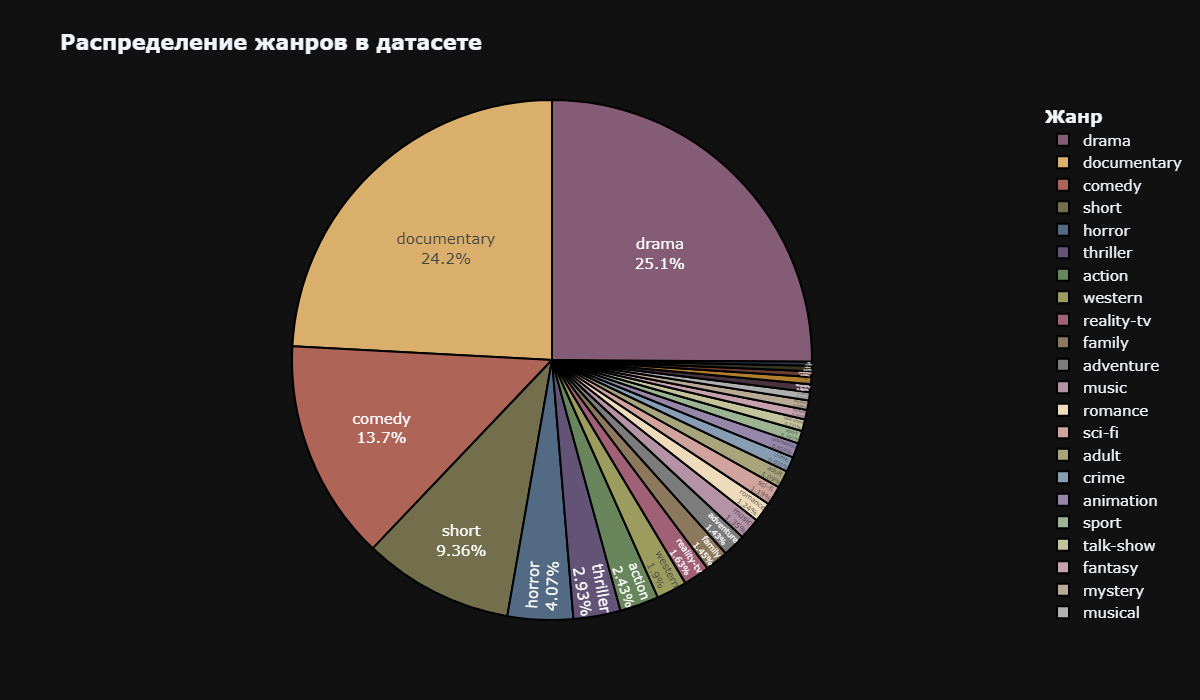

In [5]:
px.pie(
    data_frame=data_copy,
    names='genre',
    height=700,
    width=1200,
    color_discrete_sequence=px.colors.qualitative.Antique,
    title='<b>Распределение жанров в датасете</b>'
).update_traces(
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=2)), 
    textposition='inside'
).update_layout(legend_title='<b>Жанр</b>', font=dict(size=15))

Для удобства визуализируем топ-10 наиболее часто встречающихся жанров

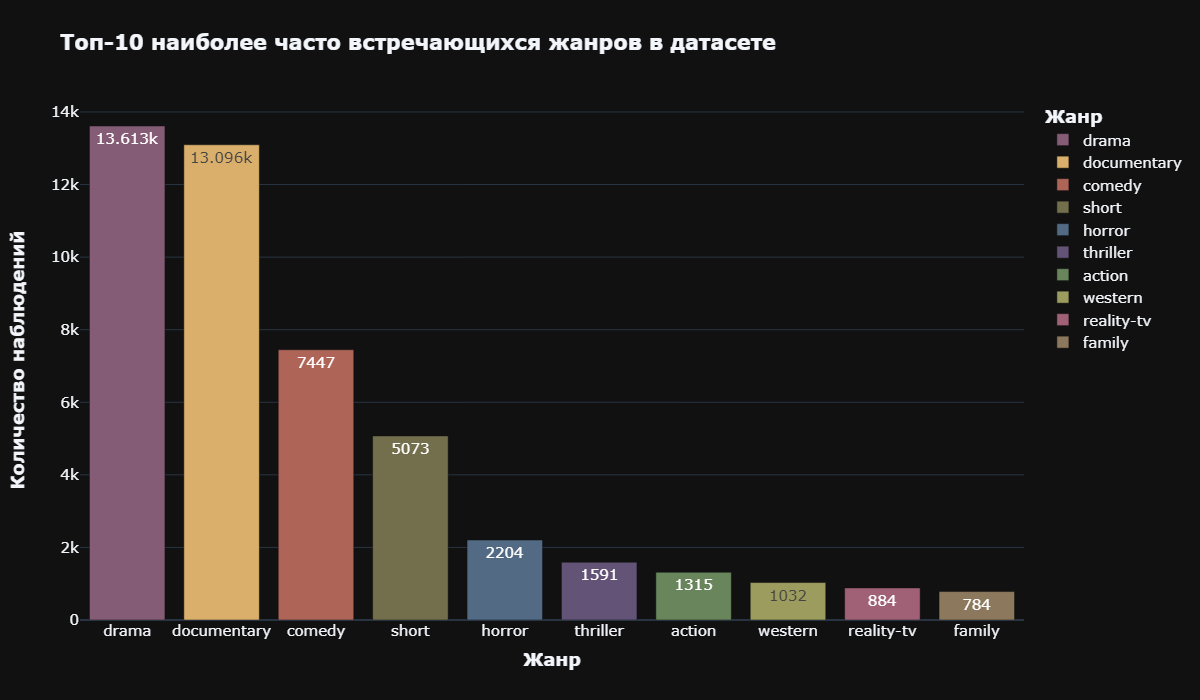

In [6]:
grouped_genre = data_copy.groupby('genre', as_index=False)['year'].count().sort_values(by='year', ascending=False).head(10)

px.bar(
    data_frame=grouped_genre,
    x='genre',
    y='year',
    color='genre',
    title='<b>Топ-10 наиболее часто встречающихся жанров в датасете</b>',
    color_discrete_sequence=px.colors.qualitative.Antique,
    text_auto=True,
    width=1200,
    height=700,
    labels={
        'genre': '<b>Жанр</b>',
        'year': '<b>Количество наблюдений</b>'
    }
).update_layout(font=dict(size=15))

<a id='visual_year'></a>

### Распределение признака `year`

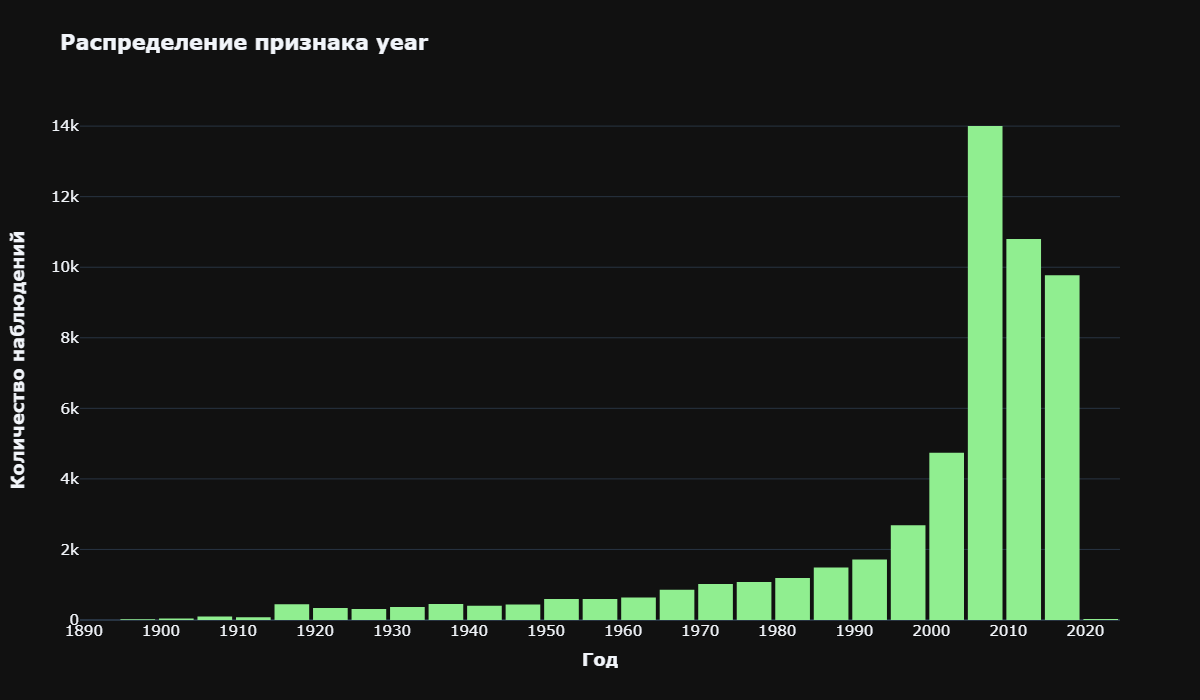

In [7]:
px.histogram(
    data_frame=data_copy,
    x='year',
    width=1200,
    height=700,
    nbins=50,
    color_discrete_sequence=['#90EE90'],
    title='<b>Распределение признака year</b>',
    labels=dict(year='<b>Год</b>')
).update_xaxes(
    tickformat='linear',
    dtick=10
).update_layout(
    bargap=0.1, 
    font=dict(size=15),
).update_yaxes(title='<b>Количество наблюдений</b>')

<a id='visual_wordcloud'></a>

### *Wordcloud* для каждого жанра
Для начала сгруппируем жанры так, чтобы признак `text` для каждого содержал все текста, относящиеся к каждому жанру

In [8]:
grouped_genre_by_text = data_copy.groupby(by='genre', as_index=False)['text'].sum()
grouped_genre_by_text

,genre,text
0,action,Dong-woo is released from prison after a shor...
1,adult,As the bus empties the students for their fie...
2,adventure,Fourteen-year-old Colm Bell and his 11-year-o...
3,animation,The story revolves around a bird called 'Humm...
4,biography,Set during the turmoil of post-Napoleonic Fra...
5,comedy,In tough economic times Max and Joey have all...
6,crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
7,documentary,Quality Control consists of a series of 16mm ...
8,drama,Listening in to a conversation between his do...
9,family,Lyle Licketti never ever does his homework. W...


Создадим трансфомер `TextTransformer`, который делает следующие операции с признаком `text` в датафрейме при вызове метода `transform`:
* Приведение текста к нижнему регистру
* Удаление служебных символов
* Лемматизация
* Удаление стоп-слов 

In [9]:
class TextTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        nltk.download('stopwords')
        nltk.download('wordnet')
    
    def fit(self, X:pd.DataFrame, y=None):
        self.stop_words = set(nltk.corpus.stopwords.words("english"))
        self.tokenizer = nltk.RegexpTokenizer(r'\w+')
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        
        def filter_stop_words(text:str):
            filtered_list = [
                word for word in text.split()
                if word not in self.stop_words
            ]
            return ' '.join(filtered_list).strip()
        
        X_copy = X.copy()
        X_copy = X.apply(
            lambda string: string.lower()
        ).apply(
            lambda string: ' '.join(self.tokenizer.tokenize(string))
        ).apply(
            self.lemmatizer.lemmatize
        ).apply(
            filter_stop_words
        )
        
        return X_copy

Применим трансформер и взглянем на результат

In [10]:
text_transformer = TextTransformer()
grouped_genre_by_text['text'] = text_transformer.fit_transform(grouped_genre_by_text['text'])
grouped_genre_by_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sadeyes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sadeyes\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,genre,text
0,action,dong woo released prison short time following ...
1,adult,bus empties students field trip museum natural...
2,adventure,fourteen year old colm bell 11 year old sister...
3,animation,story revolves around bird called hummi happy ...
4,biography,set turmoil post napoleonic france story cente...
5,comedy,tough economic times max joey run ideas discov...
6,crime,ron petrie keanu reeves troubled teen whose li...
7,documentary,quality control consists series 16mm single ta...
8,drama,listening conversation doctor parents 10 year ...
9,family,lyle licketti never ever homework whether alie...


Теперь можно визуализировать `WordCloud` для жанров

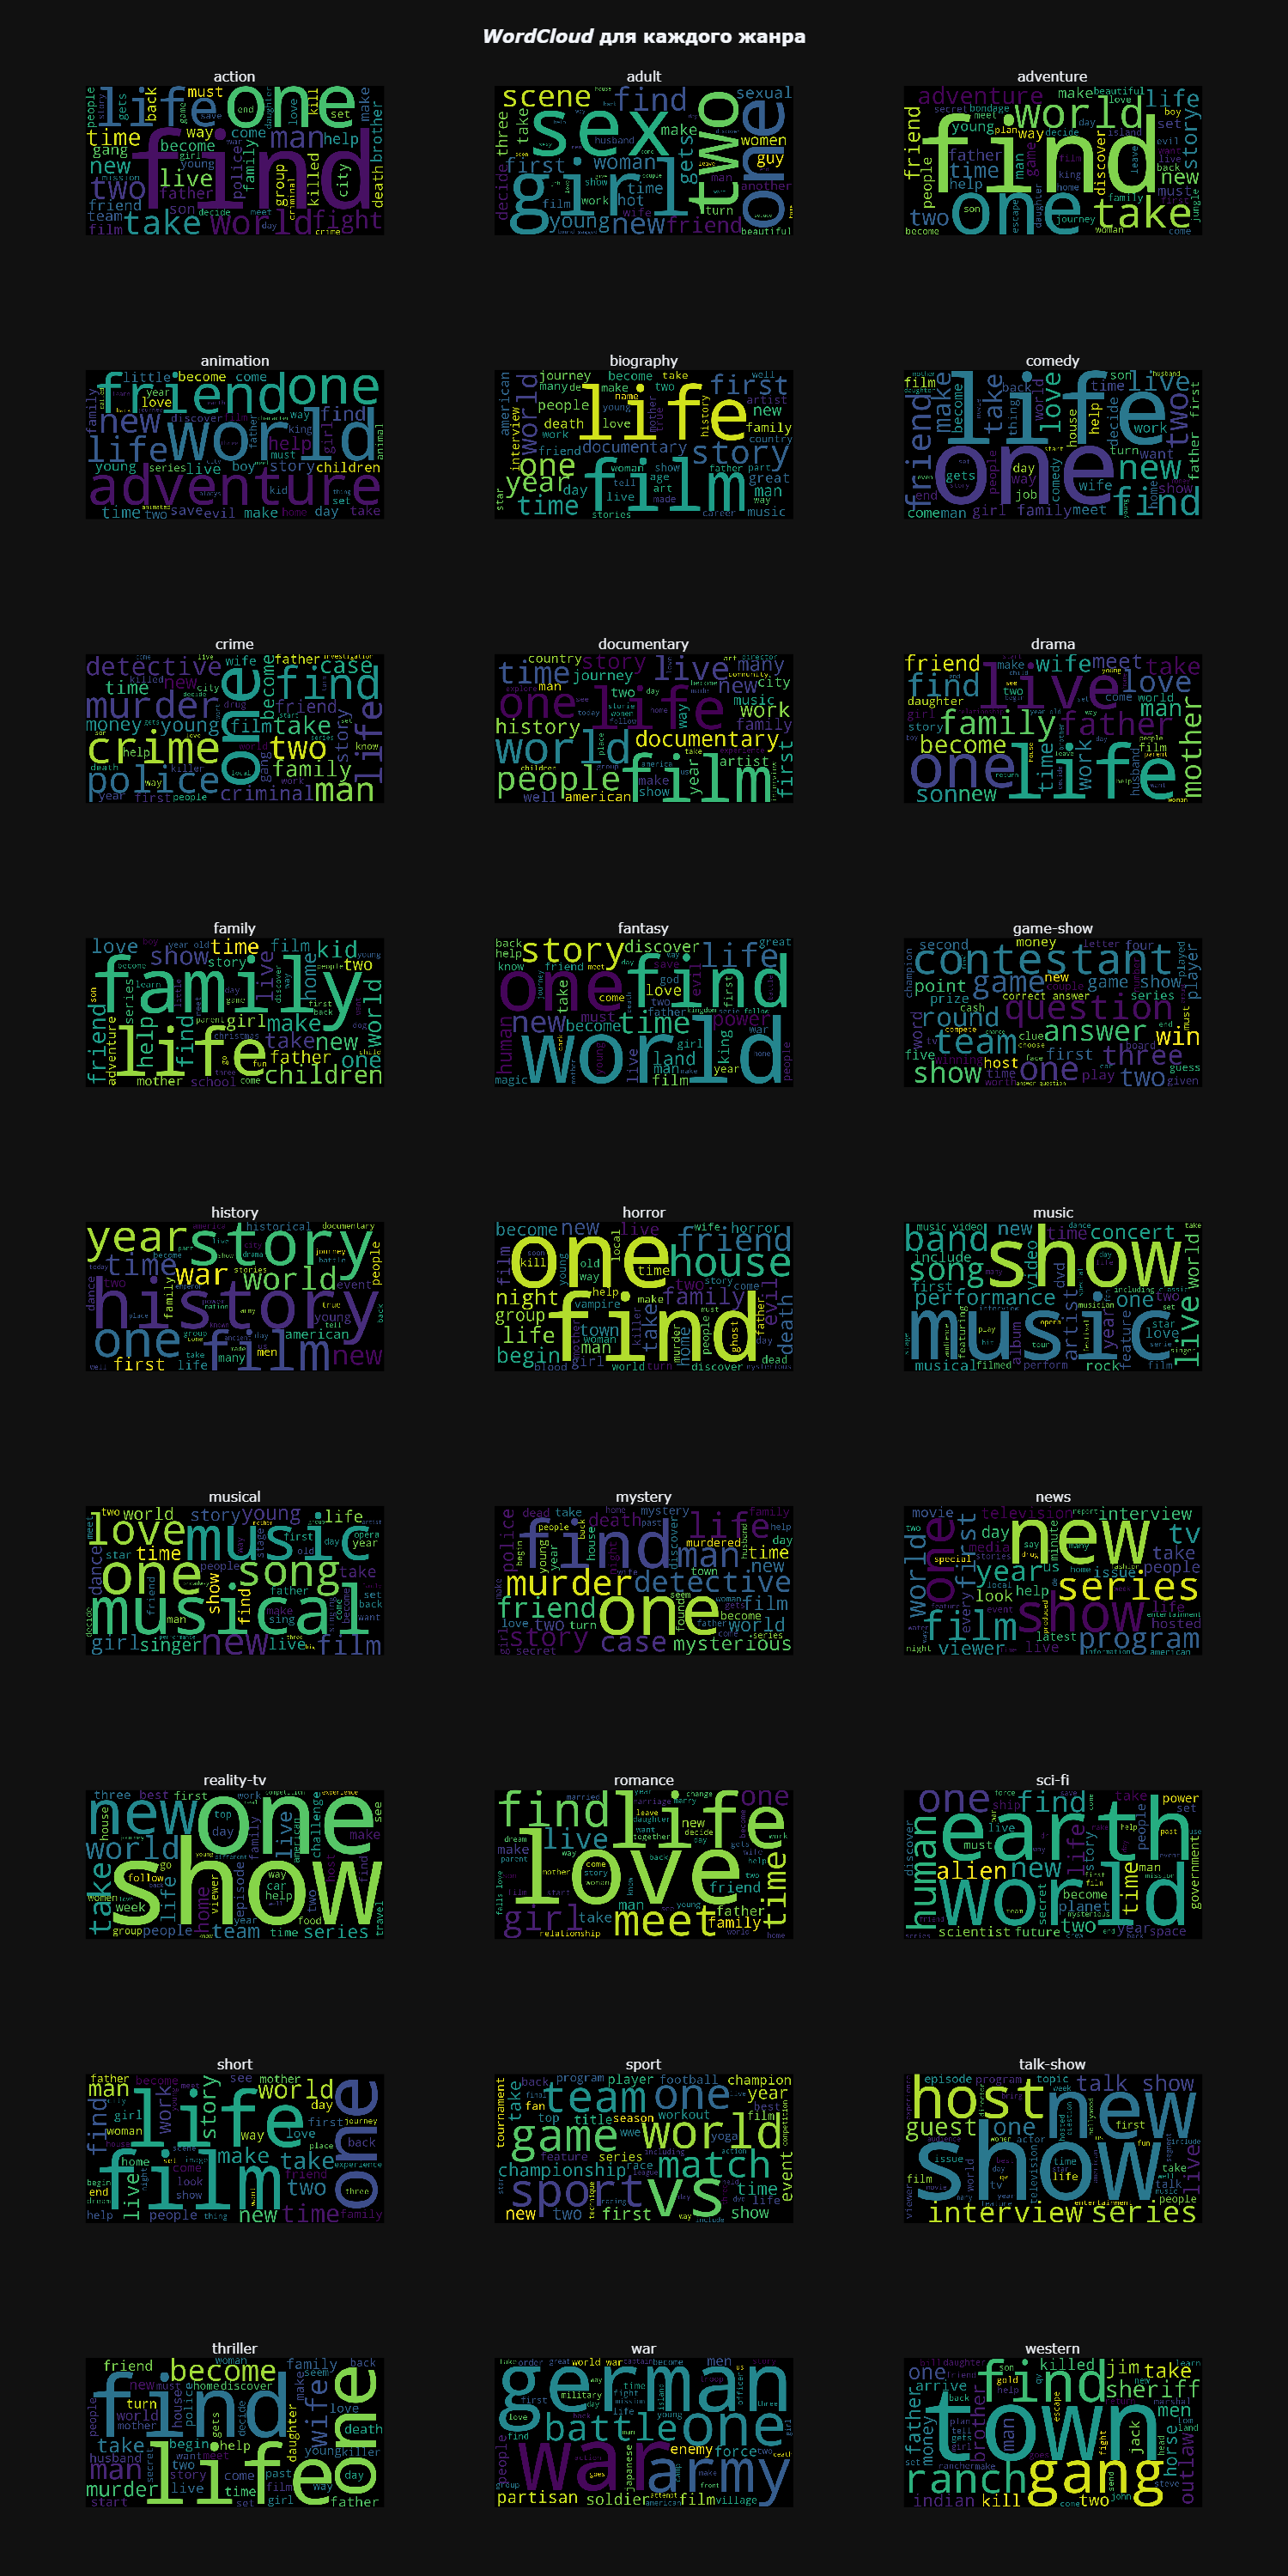

In [11]:
plots_grid = make_subplots(
    rows=9,
    cols=3,
    subplot_titles=grouped_genre_by_text['genre'].unique()
)

wc = WordCloud(
    width=1000, 
    height=500,
    colormap='viridis',
    max_words=50,
    min_font_size=6,
    min_word_length=2
)
iterators = (
    sorted(list(range(1, 10)) * 3), 
    itertools.cycle(range(1, 4)), 
    range(0, 28)
)
counter = 0

for row, col, idx in zip(*iterators):
    img = px.imshow(wc.generate(grouped_genre_by_text.loc[idx, 'text']), width=1000, height=500).data[0]
    plots_grid.add_trace(img, row=row, col=col)
    counter += 1
    if counter == grouped_genre_by_text['genre'].nunique():
        break

plots_grid.update_layout(
    height=3000,
    width=1500,
    font=dict(size=15),
    title='<b><i>WordCloud</i> для каждого жанра</b>',
    title_x=0.5
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
)

<a id='eda'></a>

## <center>EDA
Напишем трансформер для столбцов из следующих преобразований:
1. Отфильтровать текст с помощью `TextTransformer`:
    * Приведение к нижнему регистру
    * Удаление служебных символов
    * Лемматизация
2. Векторизация текста методом $TF-IDF$ с помощью `TfidfVectorizer`

In [23]:
tf_idf = TfidfVectorizer(
    input='content',
    lowercase=False,
    analyzer='word',
    max_features=100_000
)
text_preprocessing = make_pipeline(
    text_transformer,
    tf_idf
)

In [24]:
X, y = text_preprocessing.fit_transform(data['text']), data['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE)
print(
    f'Размер обучающей выборки: {X_train.shape}\n',
    f'Размер тестовой выборки: {X_test.shape}',
    end='', 
    sep=''
)

Размер обучающей выборки: (37949, 100000)
Размер тестовой выборки: (16265, 100000)

<a id='ml'></a>

## <center>ML
Для начала напишем функцию, которая будет отображать метрики для моделей, а так же записывать все результаты в словарь 

In [14]:
# Будем хранить метрики всех моделей в одном словаре
metrics_dict = {
    'model': [],
    'f1_score': [],
    'accuracy': [],
    'sample': []
}
# Функция, которая записывает метрики каждого пайплайна в словарь, а также выводит значение MAPE исследуемых моделей
def print_metrics(model) -> None:
    # Делаем предсказания для выборок и вычисляем метрики
    y_pred_train = model.fit(X_train, y_train).predict(X_train)
    y_pred_test = model.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Имя модели
    model_name = model.__class__.__name__
    # Записываем в словарь все данные о метриках модели
    metrics_dict['model'].extend([model_name, model_name])
    metrics_dict['f1_score'].extend([f1_train, f1_test])
    metrics_dict['accuracy'].extend([accuracy_train, accuracy_test])
    metrics_dict['sample'].extend(['train', 'test'])
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    # Отображаем информацию для конкретной модели
    display(Markdown(
        f'Значение метрики $F_1-score$ при использовании *{model_name}*:<br> \
        <ul><li>train: ${f1_train:.3f}$</li><li>test: ${f1_test:.3f}$</li></ul><br> \
        Значение метрики $Accuracy$ при использовании *{model_name}*:<br> \
        <ul><li>train: ${accuracy_train:.3f}$</li><li>test: ${accuracy_test:.3f}$</li></ul>'
    ))
    px.imshow(
        conf_matrix,
        x=model.classes_,
        y=model.classes_,
        width=1200,
        height=1200,
        color_continuous_scale=px.colors.diverging.RdBu_r,
        text_auto=True,
        title='<b>Confusion matrix</b>'
    ).show()

<a id='ml_logreg'></a>

### *LogisticRegression*

Значение метрики $F_1-score$ при использовании *LogisticRegression*:<br>         <ul><li>train: $0.381$</li><li>test: $0.236$</li></ul><br>         Значение метрики $Accuracy$ при использовании *LogisticRegression*:<br>         <ul><li>train: $0.717$</li><li>test: $0.573$</li></ul>

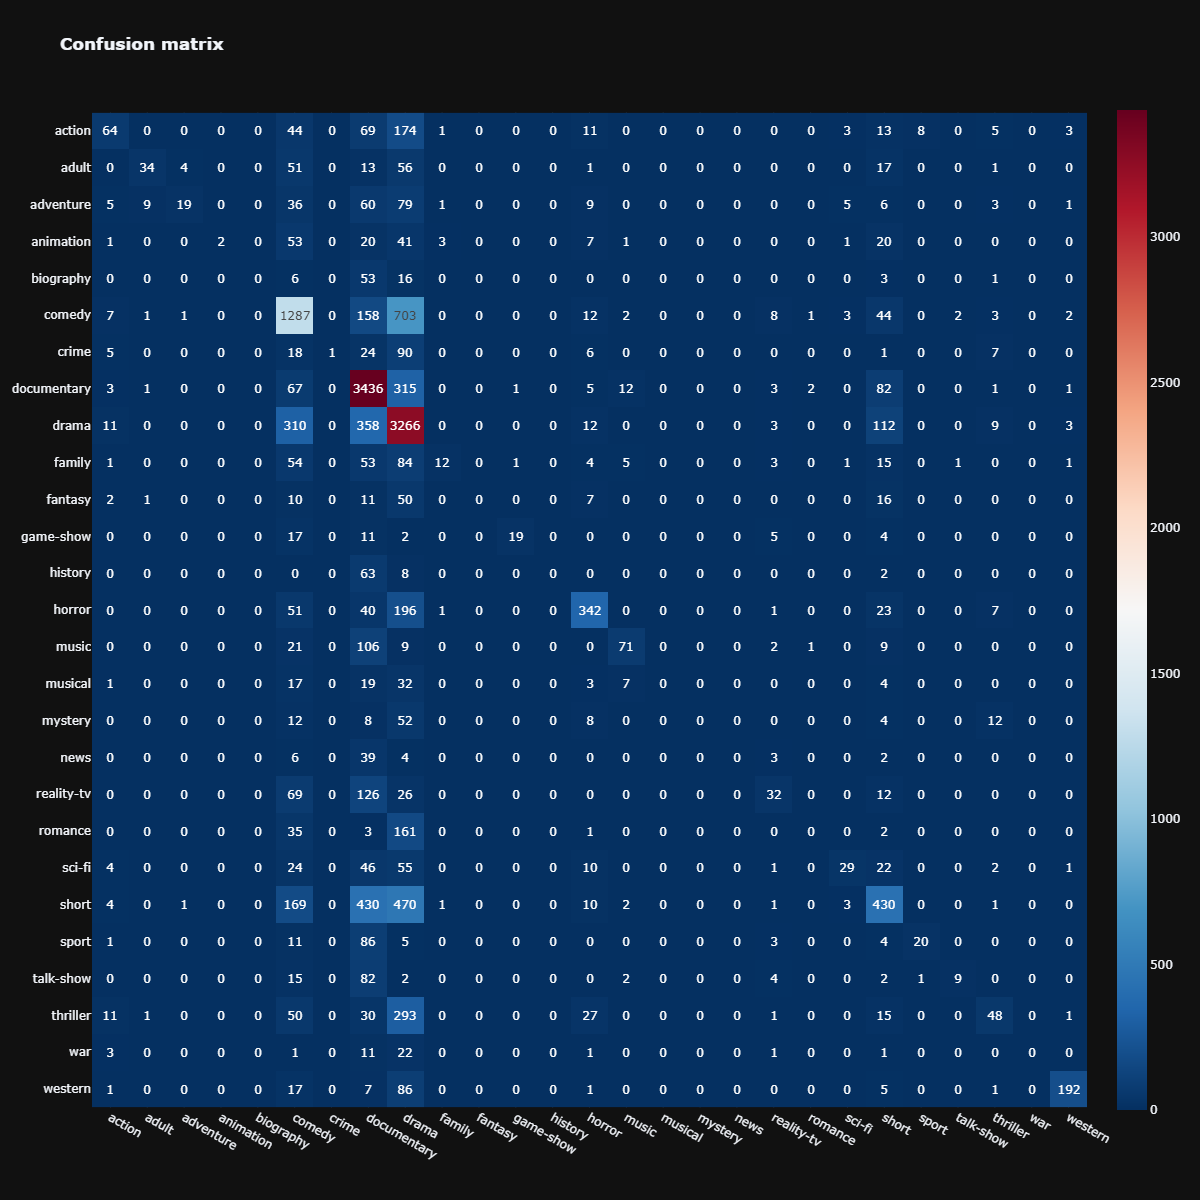

In [25]:
logreg_model = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
print_metrics(logreg_model)

<a id='ml_sgd'></a>

### *SGDClassifier*

Значение метрики $F_1-score$ при использовании *SGDClassifier*:<br>         <ul><li>train: $0.706$</li><li>test: $0.277$</li></ul><br>         Значение метрики $Accuracy$ при использовании *SGDClassifier*:<br>         <ul><li>train: $0.776$</li><li>test: $0.573$</li></ul>

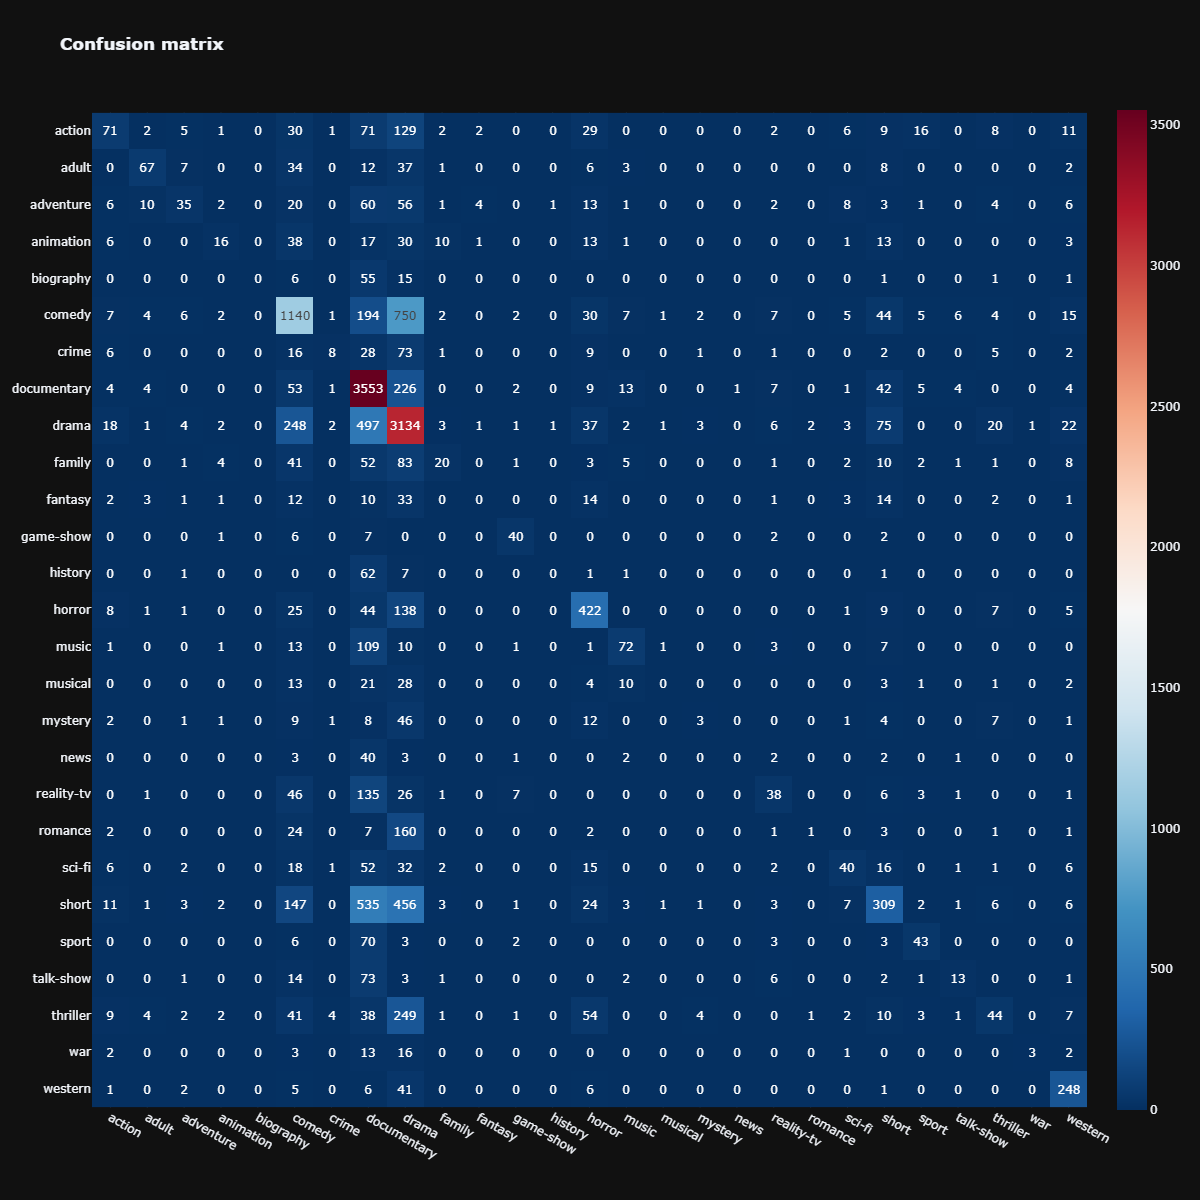

In [26]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE, max_iter=100000)
print_metrics(sgd_clf)

<a id='ml_mnb'></a>

### *MultinomialNB*

Значение метрики $F_1-score$ при использовании *MultinomialNB*:<br>         <ul><li>train: $0.053$</li><li>test: $0.047$</li></ul><br>         Значение метрики $Accuracy$ при использовании *MultinomialNB*:<br>         <ul><li>train: $0.470$</li><li>test: $0.444$</li></ul>

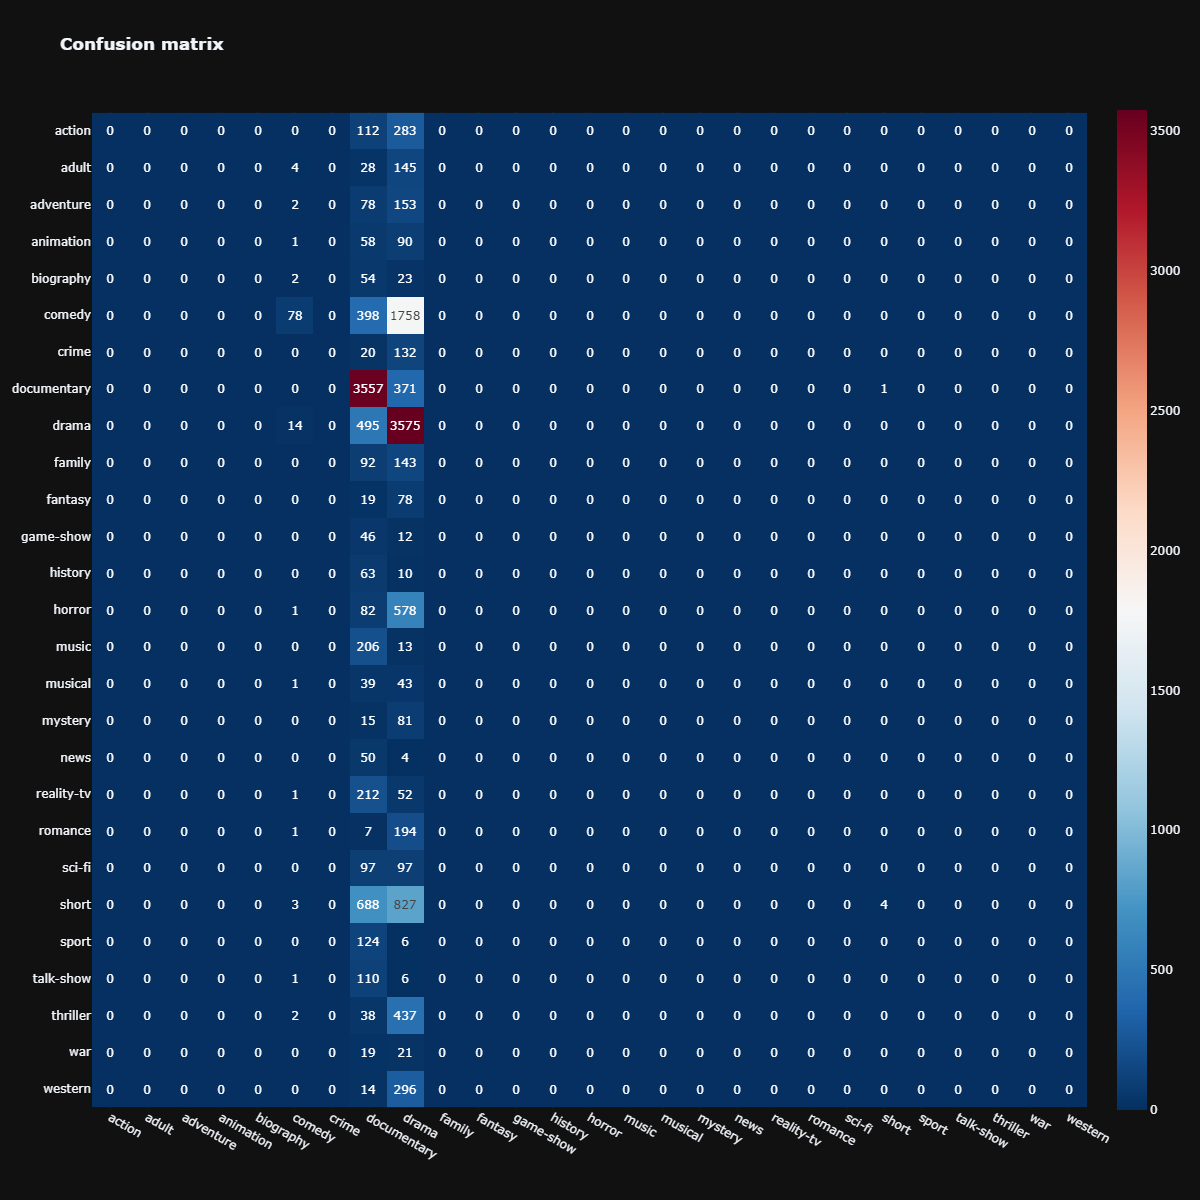

In [27]:
mnb = MultinomialNB()
print_metrics(mnb)

<a id='ml_cnb'></a>

### *ComplementNB*

Значение метрики $F_1-score$ при использовании *ComplementNB*:<br>         <ul><li>train: $0.497$</li><li>test: $0.190$</li></ul><br>         Значение метрики $Accuracy$ при использовании *ComplementNB*:<br>         <ul><li>train: $0.688$</li><li>test: $0.521$</li></ul>

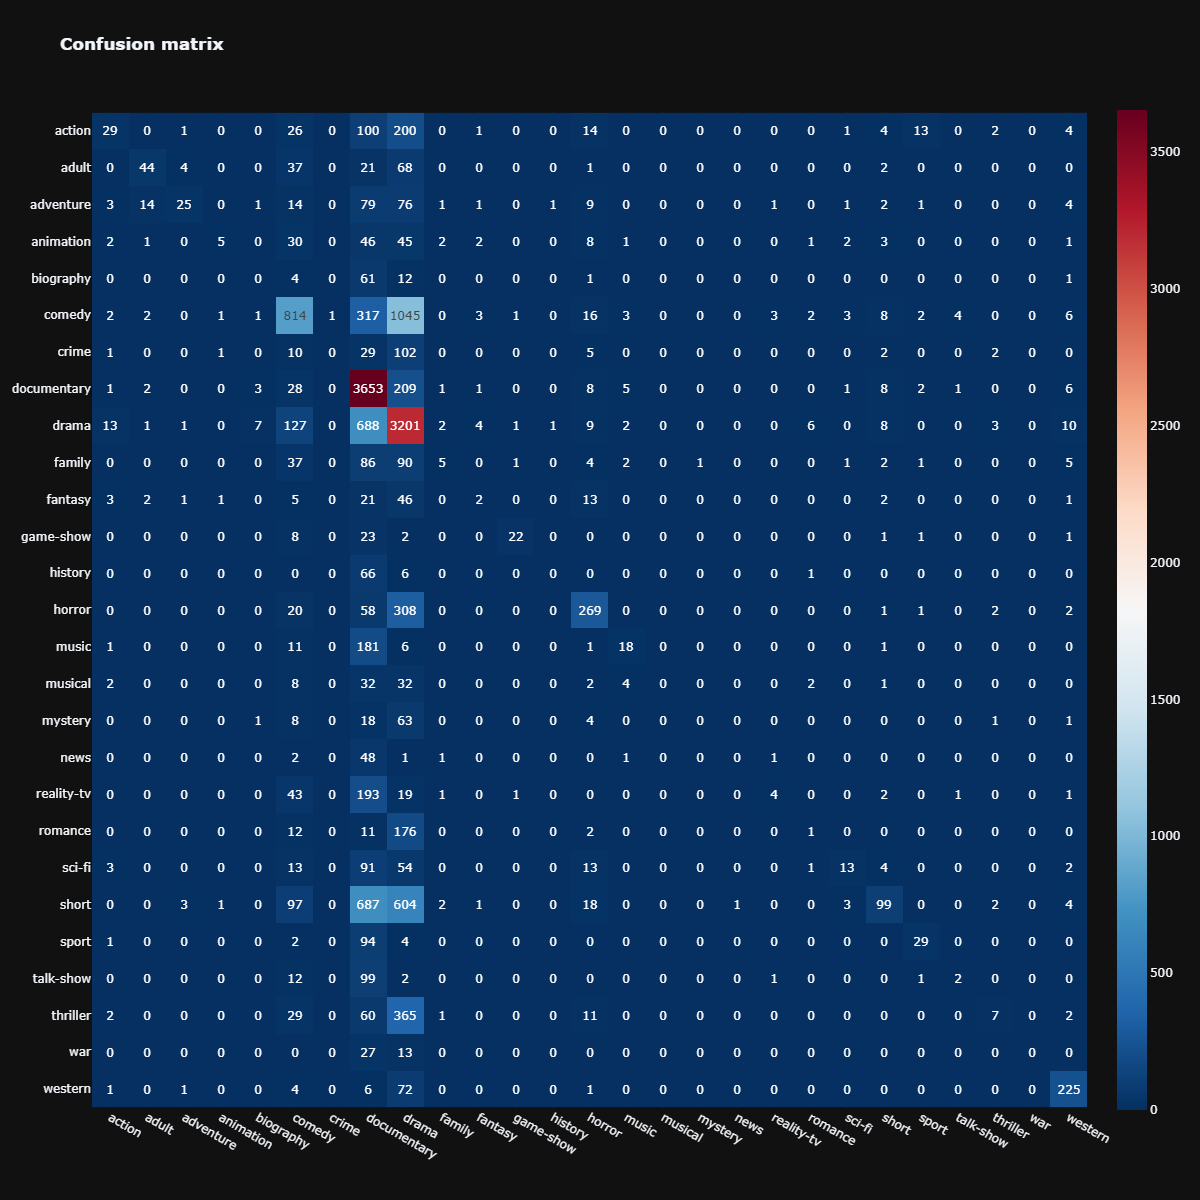

In [28]:
cnb = ComplementNB()
print_metrics(cnb)

<a id='ml_cnb'></a>

## <center>DeepLearning

In [4]:
tf.config.list_physical_devices('GPU')

AttributeError: module 'tensorflow' has no attribute 'config'